# SCMs in Code

## Exercise, Stress, Diet and Health

Recall we posit the following causal graph for how health is related to exercise, stress and diet.

```{tikz} Causal Graph Example
:xscale: 50

\usetikzlibrary{arrows.meta, positioning, shapes, backgrounds}

\definecolor{darkred}{RGB}{160,0,0}
\definecolor{darkblue}{RGB}{7, 90, 224}
\definecolor{nicegreen}{RGB}{43, 194, 88}
\definecolor{niceorange}{RGB}{255, 221, 0}

\definecolor{mediumgray}{RGB}{120,120,120}

\tikzset{arrow/.style={
    -{Latex[length=3mm, width=2mm]}, % Arrow tip configuration
    line width=0.4mm, % Arrow line width
    draw=mediumgray, % Use the medium gray color for the arrow
}}

\begin{tikzpicture}[node distance=1.5cm and 2.5cm, 
                    mynode/.style={circle, draw=none, minimum size=0.7cm,outer sep=1pt, font=\sffamily}]
    % Nodes
    \node[mynode, shape=circle, fill=darkblue!40!white] (E) {$E$};
    \node[mynode, below right= 0.5cm and 1.6cm of E, shape=circle, fill=darkblue!40!white] (H) {$H$};
    \node[mynode, below =of E, shape=circle, fill=darkblue!40!white] (D) {$D$};
    \node[mynode, below left =0.5cm and 1.6cm of E, shape = circle,  fill=darkblue!40!white] (S) {$S$};

    % Edges
    \draw[arrow] (S) -- (E);
    \draw[arrow] (E) -- (H);
    \draw[arrow] (D) -- (H);
    \draw[arrow] (S) -- (H);
\end{tikzpicture}

```

In this example, we use synthetic data to demonstrate Causal Inference.

### Loading Packages


In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

style.use("fast")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# Set seed for reproducibility
np.random.seed(42)

### Generating Synthetic Data

To generate synthetic data, we use a linear relationship between each of the variables. 

In [4]:
# Re-import libraries and regenerate the initial synthetic data with E as a binary variable
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Seed for reproducibility

# Generate synthetic data
n = 1000  # Number of samples
S = np.random.normal(loc=20, scale=5, size=n)  # Stress levels
D = np.random.uniform(low=0, high=10, size=n)  # Diet quality
E = (np.random.uniform(0, 1, size=n) < (-0.6 - 0.04 * (S - 50))).astype(int)  # Exercise: 1 for high, 0 for low, influenced by S
H = 2 + 0.5 * S - 0.6 * D + 5 * E + np.random.normal(loc=0, scale=1, size=n)  # Health status

# DataFrame
df = pd.DataFrame({'Stress': S, 'Diet': D, 'Exercise': E, 'Health': H})
df.head()

,Stress,Diet,Exercise,Health
0,22.483571,1.674826,1,16.630190
1,19.308678,1.045678,1,16.238216
2,23.238443,6.364302,1,16.000719
3,27.615149,7.064757,0,11.076818
4,18.829233,0.315861,0,9.348547


## Estimating a Causal Effect

We seek to estimate the causal effect of Exercise ($E$) on Health ($H$). From previous arguments, we can compute this as:

$$  \text{Pr}(H | \text{do}(E = \text{high})) = \sum_{S,D} \text{Pr}(H | S, D, E = \text{high}) \text{Pr}(S) \text{Pr}(D). $$

In order to estimate this, we:

1. Posit a statistical model for the distributions involved in the computation. For this example, we require $\text{Pr}(H | S, D, E)$, $\text{Pr}(S)$ and $\text{Pr}(D)$.
2. Fit the models to the data
3. Estimate the causal effect using the formula above. Since $S$ and $D$ are continuous here, we will use Monte-Carlo.

For $\text{Pr}(H | S, D, E)$, we will use linear regression (here $U_H$ is Gaussian noise):

$$ H = \beta_0 + \beta_1 S + \beta_2 D + \beta_3 E + U_H. $$

For the other probabilities, we could posit a model. However, we will just use their true distributions.

### Fit the model

In [136]:
# Fit the linear regression model for Pr(H | S, D, E)
X = df[['Stress', 'Diet', 'Exercise']]  # Independent variables
Y = df['Health']  # Dependent variable
X = sm.add_constant(X)  # Add a constant term for the intercept

model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Health   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     3712.
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        11:52:30   Log-Likelihood:                -1376.3
No. Observations:                1000   AIC:                             2761.
Df Residuals:                     996   BIC:                             2780.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8145      0.168     10.832      0.000       1.486       2.143
Stress         0.5008      0.007     75.492      0.000       0.488       0.514
Diet          -0.5748      0.011    -53.969      0.000      -0.596      -0.554
Exercise       5.0584      0.068     74.534      0.000       4.925       5.192
==============================================================================
Omnibus:                        1.189   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.552   Jarque-Bera (JB):                1.222
Skew:                          -0.083   Prob(JB):                        0.543
Kurtosis:                       2.959   Cond. No.                         121.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Monte-Carlo simulation

#### Sampling $H | \text{do}(E=high)$.

Next, we will generate samples from $H | \text{do}(E=high)$.

In [137]:
## Generate samples for S and D from their original distributions
n_mc = 10000  # Number of Monte Carlo samples
S_samples = np.random.normal(loc=20, scale=5, size=n_mc)
D_samples = np.random.uniform(low=0, high=10, size=n_mc)

## Perform Monte Carlo simulation to estimate Pr(H | do(E = high))

# Set E to high (1) for all samples in the Monte Carlo simulation
E_high = np.ones(n_mc)

# Prepare the data for prediction, including the constant term
X_mc = np.column_stack((np.ones(n_mc), S_samples, D_samples, E_high))

# Predict H using the corrected model and input structure
H_do_Ehigh = model.predict(X_mc)
average_H_do_Ehigh = np.mean(H_do_Ehigh)

print(average_H_do_Ehigh)

13.989103414918127


#### Visualisation

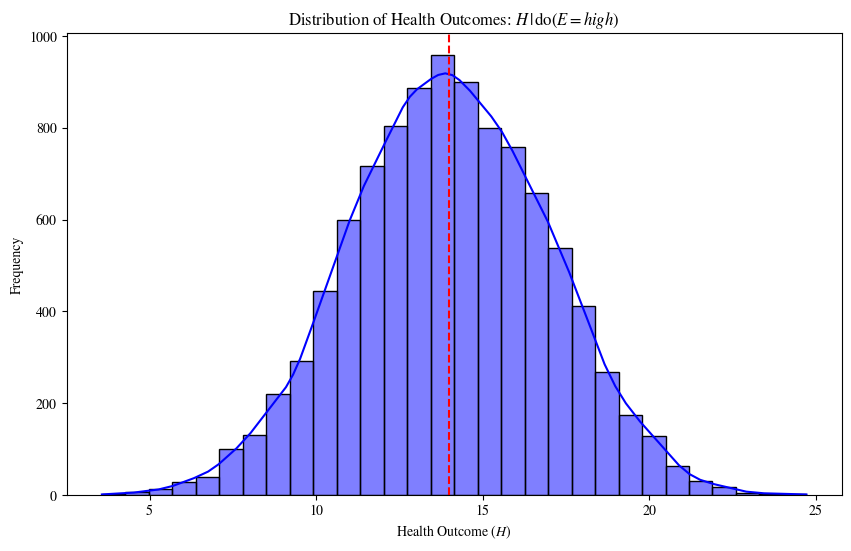

In [138]:
plt.figure(figsize=(10, 6))
sns.histplot(H_do_Ehigh, bins=30, kde=True, color='blue')
plt.axvline(x=average_H_do_Ehigh, color='red', linestyle='--', label=f'Average Causal Effect: {average_H_do_Ehigh:.2f}')
plt.title('Distribution of Health Outcomes: $H \, | \, \\text{do}(E=high)$')
plt.xlabel('Health Outcome ($H$)')
plt.ylabel('Frequency')
plt.show()

#### Sampling $H | \text{do}(E=low)$.

In [139]:
## Generate samples for S and D from their original distributions
n_mc = 10000  # Number of Monte Carlo samples
S_samples = np.random.normal(loc=20, scale=5, size=n_mc)
D_samples = np.random.uniform(low=0, high=10, size=n_mc)

## Perform Monte Carlo simulation to estimate Pr(H | do(E = low))

# Set E to high (1) for all samples in the Monte Carlo simulation
E_low = np.zeros(n_mc)

# Prepare the data for prediction, including the constant term
X_mc = np.column_stack((np.ones(n_mc), S_samples, D_samples, E_low))

# Predict H using the corrected model and input structure
H_do_Elow = model.predict(X_mc)
average_H_do_Elow = np.mean(H_do_Elow)

print(average_H_do_Elow)

8.966886531178082


#### Visualisation

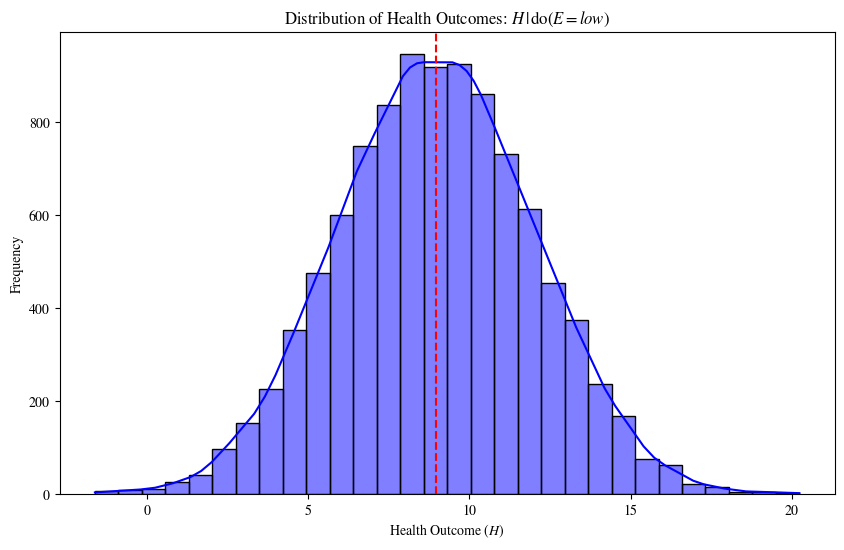

In [140]:
plt.figure(figsize=(10, 6))
sns.histplot(H_do_Elow, bins=30, kde=True, color='blue')
plt.axvline(x=average_H_do_Elow, color='red', linestyle='--', label=f'Average Causal Effect: {average_H_do_Elow:.2f}')
plt.title('Distribution of Health Outcomes: $H \, | \, \\text{do}(E=low)$')
plt.xlabel('Health Outcome ($H$)')
plt.ylabel('Frequency')
plt.show()

### Validating Faithfulness

#### Sensitivity Analysis

Using our ongoing example, we consider how sensitivity analysis can be used to verify *faithfulness*. We do this by first assuming an incorrect DAG and modify it. Our initial (incorrect) Causal Graph is:


```{tikz} Incorrect Causal Model
:xscale: 50

\usetikzlibrary{arrows.meta, positioning, shapes, backgrounds}

\definecolor{darkred}{RGB}{160,0,0}
\definecolor{darkblue}{RGB}{7, 90, 224}
\definecolor{nicegreen}{RGB}{43, 194, 88}
\definecolor{niceorange}{RGB}{255, 221, 0}

\definecolor{mediumgray}{RGB}{120,120,120}

\tikzset{arrow/.style={
    -{Latex[length=3mm, width=2mm]}, % Arrow tip configuration
    line width=0.4mm, % Arrow line width
    draw=mediumgray, % Use the medium gray color for the arrow
}}

\begin{tikzpicture}[node distance=1.5cm and 2.5cm, 
                    mynode/.style={circle, draw=none, minimum size=0.7cm,outer sep=1pt, font=\sffamily}]
    % Nodes
    \node[mynode, shape=circle, fill=darkblue!40!white] (E) {$E$};
    \node[mynode, below right= 0.5cm and 1.6cm of E, shape=circle, fill=darkblue!40!white] (H) {$H$};
    \node[mynode, below =of E, shape=circle, fill=darkblue!40!white] (D) {$D$};
    \node[mynode, below left =0.5cm and 1.6cm of E, shape = circle,  fill=darkblue!40!white] (S) {$S$};

    % Edges
    \draw[arrow] (S) -- (E);
    \draw[arrow] (E) -- (H);
    \draw[arrow] (D) -- (H);
\end{tikzpicture}

```




In [21]:
n = 1000  # Number of samples
S = np.random.normal(loc=20, scale=5, size=n)  # Stress levels
D = np.random.uniform(low=0, high=10, size=n)  # Diet quality
E = (np.random.uniform(0, 1, size=n) < (-0.6 - 0.04 * (S - 50))).astype(int)  # Exercise: 1 for high, 0 for low, influenced by S
H = 400 - 20 * S - 0.6 * D + 5 * E + np.random.normal(loc=0, scale=1, size=n)  # Health status


In [22]:
# Creating the DataFrame
df = pd.DataFrame({'Stress': S, 'Diet': D, 'Exercise': E, 'Health': H})

# Fit the linear regression model for Pr(H | D, E)
X = df[['Diet', 'Exercise']]  # Independent variables
Y = df['Health']  # Dependent variable
X = sm.add_constant(X)  # Add a constant term for the intercept

model = sm.OLS(Y, X).fit()
print(model.summary())

# Perform Monte Carlo simulation to estimate Pr(H | do(E = high))
n_mc = 10000  # Number of Monte Carlo samples
S_samples = np.random.normal(loc=20, scale=5, size=n_mc)
D_samples = np.random.uniform(low=0, high=10, size=n_mc)

# Set E to high (1) for all samples in the Monte Carlo simulation
E_high = np.ones(n_mc)

# Prepare the data for prediction, including the constant term
X_mc_high = np.column_stack((np.ones(n_mc), D_samples, E_high))

# Predict H using the model and input structure for high exercise
H_do_Ehigh = model.predict(X_mc_high)
average_H_do_Ehigh = np.mean(H_do_Ehigh)

# Perform Monte Carlo simulation to estimate Pr(H | do(E = low))
# Set E to low (0) for all samples in the Monte Carlo simulation
E_low = np.zeros(n_mc)

# Prepare the data for prediction, including the constant term
X_mc_low = np.column_stack((np.ones(n_mc), D_samples, E_low))

# Predict H using the model and input structure for low exercise
H_do_Elow = model.predict(X_mc_low)
average_H_do_Elow = np.mean(H_do_Elow)

print(f"Average Health Outcome | do(E=high): {average_H_do_Ehigh}")
print(f"Average Health Outcome | do(E=low): {average_H_do_Elow}")

                            OLS Regression Results                            
Dep. Variable:                 Health   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     107.9
Date:                Fri, 01 Mar 2024   Prob (F-statistic):           3.97e-43
Time:                        12:52:59   Log-Likelihood:                -5917.5
No. Observations:                1000   AIC:                         1.184e+04
Df Residuals:                     997   BIC:                         1.186e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -49.3245      6.721     -7.339      0.0

In [24]:
# Creating the DataFrame
df = pd.DataFrame({'Stress': S, 'Diet': D, 'Exercise': E, 'Health': H})

# Fit the linear regression model for Pr(H | D, E)
X = df[['Stress', 'Diet', 'Exercise']]  # Independent variables
Y = df['Health']  # Dependent variable
X = sm.add_constant(X)  # Add a constant term for the intercept

model = sm.OLS(Y, X).fit()

# Prepare the data for prediction, including the constant term
X_mc_high = np.column_stack((np.ones(n_mc), S_samples, D_samples, E_high))

# Predict H using the model and input structure for high exercise
H_do_Ehigh = model.predict(X_mc_high)
average_H_do_Ehigh = np.mean(H_do_Ehigh)

# Perform Monte Carlo simulation to estimate Pr(H | do(E = low))
# Set E to low (0) for all samples in the Monte Carlo simulation
E_low = np.zeros(n_mc)

# Prepare the data for prediction, including the constant term
X_mc_low = np.column_stack((np.ones(n_mc), S_samples, D_samples, E_low))

# Predict H using the model and input structure for low exercise
H_do_Elow = model.predict(X_mc_low)
average_H_do_Elow = np.mean(H_do_Elow)

print(f"Average Health Outcome | do(E=high): {average_H_do_Ehigh}")
print(f"Average Health Outcome | do(E=low): {average_H_do_Elow}")

Average Health Outcome | do(E=high): 1.7265694720299742
Average Health Outcome | do(E=low): -3.4292296570386918
